In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\Arjun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# path of the current directory
cur_dir = os.getcwd()
data_path = cur_dir+"/drugsCom"
whole_path = "test_dataset.csv"

In [3]:
whole = pd.read_csv(whole_path)
fda_path = data_path + "/drugs_recalls_fda.tsv"
fda = pd.read_csv(fda_path, sep='\t')
whole['partial_name'] = whole['drugName'].apply(lambda x: x.split('/')[0].strip().lower())

whole['is_recalled'] = whole['partial_name'].apply(lambda x: fda['Product Description'].str.contains(x, case=False, regex=False).any())


whole.head()

,Unnamed: 0,Unnamed: 0.1,drugName,condition,review,rating,date,usefulCount,Sentimental_Polarity,Sentimental_Subjectivity,partial_name,is_recalled
0,0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22,-0.300000,0.550000,mirtazapine,False
1,1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17,0.333333,0.566667,mesalamine,False
2,2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3,0.333333,0.500000,bactrim,False
3,3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,0.253125,0.575000,contrave,False
4,4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4,0.204792,0.526458,cyclafem 1,False


In [4]:
print(whole.shape)
whole['is_recalled'] = whole['is_recalled'].astype(int)
whole['is_recalled'].sum()


(53766, 12)


5516

In [5]:
# No missing values
whole = whole[["Sentimental_Subjectivity", "Sentimental_Polarity","is_recalled"]]
assert(whole.isnull().values.any() == False)
X = whole.iloc[:, 0:whole.shape[1]-1]
y = whole.iloc[:, whole.shape[1]-1]
print(y.head())
print(X.head())
y= y.values.reshape([-1, 1])

0    0
1    0
2    0
3    0
4    0
Name: is_recalled, dtype: int32
   Sentimental_Subjectivity  Sentimental_Polarity
0                  0.550000             -0.300000
1                  0.566667              0.333333
2                  0.500000              0.333333
3                  0.575000              0.253125
4                  0.526458              0.204792


In [6]:
# X = whole.iloc[:, 0:whole.shape[1]-1].values
# y = whole.iloc[:, whole.shape[1]-1].values.reshape([-1, 1])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [7]:
def get_train_test(whole, downsample = False, n_is_called = 1, seed = 1234):
    X = whole.iloc[:, 0:whole.shape[1]-1].values
    y = whole.iloc[:, whole.shape[1]-1].values.reshape([-1, 1])
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    y_test = y_test.reshape((-1,1))

    if downsample == False:
        y_train = y_train.reshape((-1,1))
        return X_train, y_train, X_test, y_test
    else:
        not_recalled_idx = [x for x in range(y_train.shape[0]) if y_train[x]==0]
        is_recalled_idx = [x for x in range(y_train.shape[0]) if y_train[x]==1]
        assert len(not_recalled_idx) + sum(y_train)[0] == y_train.shape[0]
        chose = np.random.choice(not_recalled_idx, int(n_is_called * sum(y_train)[0]), replace=False)
        X_train_downsample = np.vstack((X_train[chose, :],X_train[is_recalled_idx, :]))
        y_train_downsample = np.vstack((y_train[chose, :], y_train[y_train==1].reshape((-1, 1))))
        y_train_downsample = y_train_downsample.reshape((-1, 1))
        return X_train_downsample, y_train_downsample, X_test, y_test


In [8]:
from sklearn.metrics import confusion_matrix
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [9]:
n_recalled = whole[whole['is_recalled']==1].shape[0]
n_not_recalled = whole[whole['is_recalled']==0].shape[0]
n_not_recalled / whole.shape[0]

0.8974072834133096

In [10]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [11]:
# inputs
training_epochs = 1000
learning_rate = 0.01
num_inputs = 2    # 2 independent variables

cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,num_inputs])
Y = tf.placeholder(tf.float32,[None,1])
is_training=tf.Variable(True,dtype=tf.bool)


num_hid1 = 16
num_hid2 = 8
num_output = 1 # is_recalled/not_recalled

In [12]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 1)
#y_train_ = y_train.reshape((y_train.shape[0],1))
#y_test_ = y_test.reshape((y_test.shape[0],1))

In [13]:
# models

initializer = tf.contrib.layers.xavier_initializer()
h1 = tf.layers.dense(X, num_hid1, activation=tf.nn.relu, kernel_initializer=initializer, name = 'h1')
h2 = tf.layers.dense(h1, num_hid2, activation=tf.nn.relu, kernel_initializer=initializer, name = 'h2')
output = tf.layers.dense(h2, num_output, activation=None, name = 'output')

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=output)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


predicted = tf.round(tf.nn.sigmoid(output))
correct_pred = tf.equal(predicted, Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Step:     0	Loss: 0.696	Acc: 50.20%
Step:   100	Loss: 0.689	Acc: 53.76%
Step:   200	Loss: 0.688	Acc: 53.70%
Step:   300	Loss: 0.687	Acc: 54.24%
Step:   400	Loss: 0.687	Acc: 54.33%
Step:   500	Loss: 0.687	Acc: 54.22%
Step:   600	Loss: 0.687	Acc: 54.15%
Step:   700	Loss: 0.687	Acc: 54.68%
Step:   800	Loss: 0.686	Acc: 54.21%
Step:   900	Loss: 0.686	Acc: 54.54%
Step:  1000	Loss: 0.686	Acc: 54.17%
Test Accuracy: 0.5305642
Normalized confusion matrix
[[0.53 0.47]
 [0.5  0.5 ]]


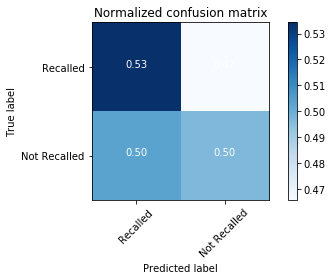

In [14]:
# session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: X_train, Y: y_train})
        loss, _, acc = sess.run([cost, optimizer, accuracy], feed_dict={
                                 X: X_train, Y: y_train})
        cost_history = np.append(cost_history, acc)
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    acc_pred = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    pred = sess.run(predicted, feed_dict={X: X_test, Y: y_test})
    print('Test Accuracy:', acc_pred)
    cnf_matrix = confusion_matrix(y_test, pred)
    np.set_printoptions(precision=2)
    class_names = ['Recalled', 'Not Recalled']
    plt.figure()
    plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')
    

Step:     0	Loss: 0.661	Acc: 59.00%
Step:   100	Loss: 0.498	Acc: 80.00%
Step:   200	Loss: 0.498	Acc: 80.00%
Step:   300	Loss: 0.498	Acc: 80.00%
Step:   400	Loss: 0.498	Acc: 80.00%
Step:   500	Loss: 0.498	Acc: 80.00%
Step:   600	Loss: 0.498	Acc: 80.00%
Step:   700	Loss: 0.498	Acc: 80.00%
Step:   800	Loss: 0.497	Acc: 80.00%
Step:   900	Loss: 0.497	Acc: 80.00%
Step:  1000	Loss: 0.497	Acc: 80.00%
Test Accuracy: 0.9009919
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


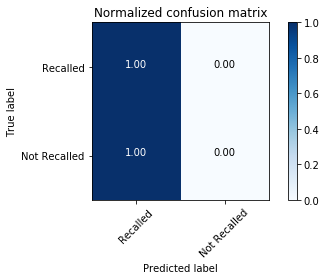

In [15]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 4)
# session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: X_train, Y: y_train})
        loss, _, acc = sess.run([cost, optimizer, accuracy], feed_dict={
                                 X: X_train, Y: y_train})
        cost_history = np.append(cost_history, acc)
        if step % 100 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    acc_pred = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    pred = sess.run(predicted, feed_dict={X: X_test, Y: y_test})
    print('Test Accuracy:', acc_pred)
    cnf_matrix = confusion_matrix(y_test, pred)
    np.set_printoptions(precision=2)
    class_names = ['Recalled', 'Not Recalled']
    plt.figure()
    plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')
    

51.02293862368258
Normalized confusion matrix
[[0.51 0.49]
 [0.47 0.53]]


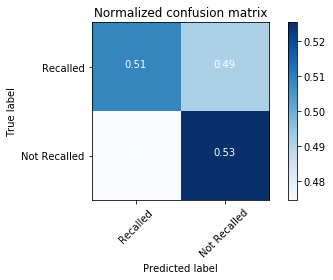

In [16]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 1)
dt_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=5, min_samples_leaf=5)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
print(accuracy_score(y_test,y_pred_gini)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_gini)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')

89.31184128952263
Normalized confusion matrix
[[0.99 0.01]
 [0.99 0.01]]


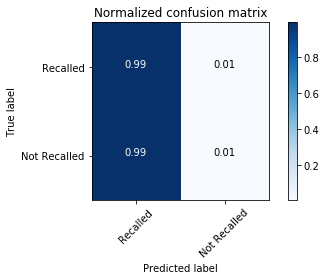

In [17]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 1.5)
dt_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=5, min_samples_leaf=5)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
print(accuracy_score(y_test,y_pred_gini)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_gini)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')

88.84686918784872
Normalized confusion matrix
[[0.98 0.02]
 [0.98 0.02]]


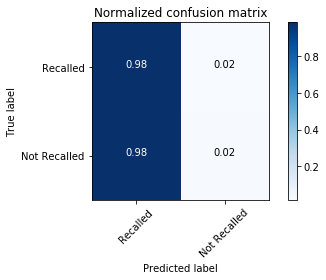

In [18]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 1.8)
dt_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=5, min_samples_leaf=5)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
print(accuracy_score(y_test,y_pred_gini)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_gini)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')

90.09299442033478
Normalized confusion matrix
[[1.00e+00 1.38e-04]
 [9.99e-01 6.26e-04]]


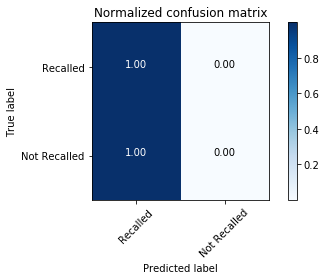

In [19]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = False)
dt_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=5, min_samples_leaf=5)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
print(accuracy_score(y_test,y_pred_gini)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_gini)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')

89.46063236205828
Normalized confusion matrix
[[0.99 0.01]
 [0.99 0.01]]


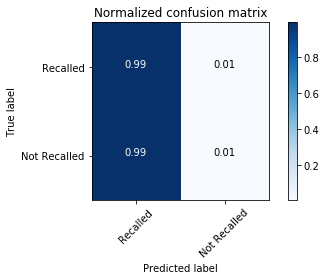

In [20]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 1.5)
dt_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)
print(accuracy_score(y_test,y_pred_entropy)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_entropy)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')

90.0991940483571
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


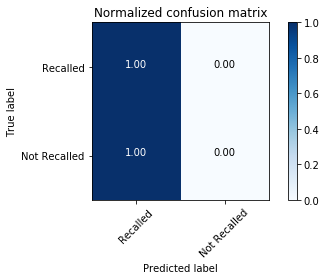

In [21]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 1.8)
dt_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)
print(accuracy_score(y_test,y_pred_entropy)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_entropy)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')

90.0991940483571
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


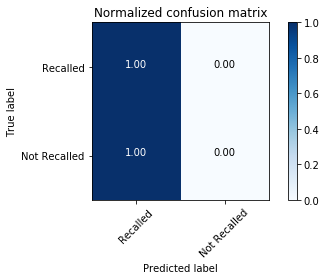

In [22]:
X_train, y_train, X_test, y_test = get_train_test(whole, downsample = True, n_is_called = 2)
dt_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)
print(accuracy_score(y_test,y_pred_entropy)*100)
cnf_matrix = confusion_matrix(y_test, y_pred_entropy)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')